In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader

/workspace/shared/apps/anaconda3/envs/torch190/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df = pd.read_csv("ml-latest-small/ratings.csv")

In [4]:
df.info() # basically show schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
df.userId.nunique()

610

In [6]:
df.movieId.nunique()

9724

In [7]:
df.rating.value_counts() #check value distribution

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [8]:
df.shape

(100836, 4)

#### Training Dataset Class Wrapper

In [9]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
    # len(movie_dataset)
    def __len__(self):
        return len(self.users)
    # movie_dataset[1] 
    def __getitem__(self, item):

        users = self.users[item] 
        movies = self.movies[item]
        ratings = self.ratings[item]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

#### Create the model

In [10]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)
        # user, movie embedding concat
        self.out = nn.Linear(64, 1)

    
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds], dim=1)
        
        output = self.out(output)
        
        return output

In [11]:
# encode the user and movie id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users=df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_valid.rating.values
)



In [12]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) 

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) 

dataiter = iter(train_loader)
dataloader_data = dataiter.next() 
print(dataloader_data)

/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),


{'users': tensor([605,  83, 379, 452]), 'movies': tensor([3509,  658, 3094, 1303]), 'ratings': tensor([4, 3, 2, 4])}


In [13]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [14]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

610
9724
9723
90752


#### Manually run a forward path

In [15]:
print(dataloader_data['users'])

print(dataloader_data['users'].size())
print(dataloader_data['movies'] )
print(dataloader_data['movies'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)

out = nn.Linear(64, 1)


tensor([605,  83, 379, 452])
torch.Size([4])
tensor([3509,  658, 3094, 1303])
torch.Size([4])


In [16]:
user_embeds = user_embed(dataloader_data['users'])
movie_embeds = movie_embed(dataloader_data['movies'])
print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")
print(f"movie_embeds {movie_embeds.size()}")
print(f"movie_embeds {movie_embeds}")

user_embeds torch.Size([4, 32])
user_embeds tensor([[-0.2520, -0.9219,  1.4858, -1.6553, -1.6857, -0.6010, -0.8813,  2.3171,
          1.1420, -0.5452,  0.6982,  1.1811, -0.4357, -0.3685,  0.2750, -0.0429,
         -0.5116,  0.5405, -0.2553, -1.7710,  0.6795,  0.8117, -0.1782,  0.0936,
          0.5063,  0.7133,  1.4532,  0.2172, -1.1686, -1.6555,  1.3895,  0.3345],
        [-1.4396, -0.8579, -0.6026,  0.2032, -1.1084, -0.3011, -1.3868, -0.4079,
         -1.1426, -0.8387,  0.4180, -0.5627, -0.3313,  1.6068,  0.0989, -2.1554,
         -0.9992,  0.7265,  1.3826, -0.2183,  1.7908,  0.1678,  0.7581, -0.8694,
         -0.4218,  0.0511,  0.1504,  0.5761,  2.4219,  1.2993,  2.2231, -1.5905],
        [ 0.5163, -0.1067, -0.3334, -0.4875, -0.3143, -0.2787,  0.2424,  0.5763,
          0.6580, -1.7541, -0.1250,  0.2865, -0.0250, -1.7641, -0.1478, -0.3840,
         -0.3825, -2.6243,  0.1302, -0.9301, -0.3957,  0.5394,  0.6767,  0.6628,
          0.7303,  0.1389, -0.7761, -0.7067,  1.5240, -1.1904, 

In [17]:
output = torch.cat([user_embeds, movie_embeds], dim=1) 
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output)
print(f"output: {output}")

output: torch.Size([4, 64])
output: tensor([[-2.5205e-01, -9.2187e-01,  1.4858e+00, -1.6553e+00, -1.6857e+00,
         -6.0103e-01, -8.8135e-01,  2.3171e+00,  1.1420e+00, -5.4518e-01,
          6.9816e-01,  1.1811e+00, -4.3574e-01, -3.6850e-01,  2.7498e-01,
         -4.2889e-02, -5.1164e-01,  5.4046e-01, -2.5533e-01, -1.7710e+00,
          6.7952e-01,  8.1169e-01, -1.7821e-01,  9.3586e-02,  5.0630e-01,
          7.1327e-01,  1.4532e+00,  2.1715e-01, -1.1686e+00, -1.6555e+00,
          1.3895e+00,  3.3448e-01,  1.4746e+00, -1.3736e+00,  2.0782e-01,
         -1.5141e-02,  2.5132e-01, -1.9066e+00,  1.0632e+00,  5.2773e-01,
          1.6183e+00, -9.1351e-01,  1.9467e-01,  4.8739e-01, -1.1913e+00,
         -1.1012e+00, -1.2242e+00, -3.9264e-01,  1.0330e+00, -1.3296e+00,
          2.3285e+00, -7.1858e-02,  2.1191e-03,  1.3590e+00,  3.1541e-01,
          6.9873e-01,  1.3637e+00, -1.4589e+00,  5.0842e-01, -1.2153e+00,
         -3.8979e-01, -1.3256e+00, -2.3512e+00,  1.9720e+00],
        [-1.43

In [18]:
with torch.no_grad():
    model_output = model(dataloader_data['users'].to(device), 
                   dataloader_data["movies"].to(device))

    print(f"model_output: {model_output}, size: {model_output.size()}")

model_output: tensor([[-0.5564],
        [ 0.6797],
        [-0.2629],
        [-0.5443]], device='cuda:0'), size: torch.Size([4, 1])


In [19]:
rating = dataloader_data["ratings"]
print(rating)
print(rating.view(4, -1))
print(model_output)

print(rating.sum())

print(model_output.sum() - rating.sum())

tensor([4, 3, 2, 4])
tensor([[4],
        [3],
        [2],
        [4]])
tensor([[-0.5564],
        [ 0.6797],
        [-0.2629],
        [-0.5443]], device='cuda:0')
tensor(13)
tensor(-13.6840, device='cuda:0')


#### Run the training loop

In [20]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"].to(device), 
                       train_data["movies"].to(device)
                      ) 
        
        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        rating = train_data["ratings"].view(4, -1).to(torch.float32).to(device)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),


epoch 0 loss at step: 5000 is 0.5101097367048264
epoch 0 loss at step: 10000 is 0.18411675513386727
epoch 0 loss at step: 15000 is 0.11208086706530303
epoch 0 loss at step: 20000 is 0.08568620623815805
epoch 0 loss at step: 25000 is 0.0691491937073879
epoch 0 loss at step: 30000 is 0.06542395735876634
epoch 0 loss at step: 35000 is 0.0672071553981863
epoch 0 loss at step: 40000 is 0.06361753194155172
epoch 0 loss at step: 45000 is 0.06026220014132559
epoch 0 loss at step: 50000 is 0.06088470030361787
epoch 0 loss at step: 55000 is 0.06050228049024008
epoch 0 loss at step: 60000 is 0.0552825854354538
epoch 0 loss at step: 65000 is 0.06011045858934522
epoch 0 loss at step: 70000 is 0.05844800607636571
epoch 0 loss at step: 75000 is 0.059422189733479173
epoch 0 loss at step: 80000 is 0.057488630441110584
epoch 0 loss at step: 85000 is 0.05840645083812997
epoch 0 loss at step: 90000 is 0.056306275022495536


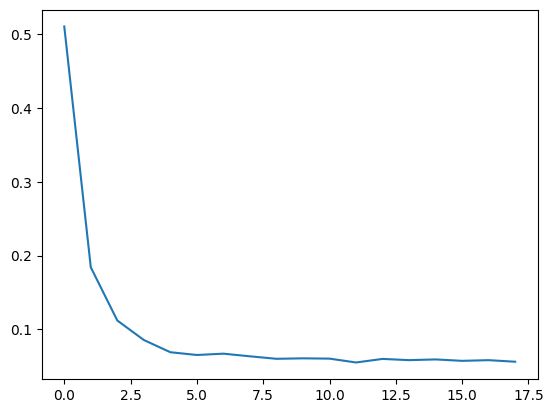

In [21]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

##### Evaluation with RMSE


In [22]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'].to(device), 
                       batched_data["movies"].to(device))
        
        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"].to(device)
        
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

#         print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")

/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),


rms: 0.46449074555714354


##### Evaluation with Recall@K


In [23]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user 
user_est_true = defaultdict(list)

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]   
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        users = batched_data['users']
        movies = batched_data['movies']
        ratings = batched_data['ratings']
        
        model_output = model(batched_data['users'].to(device), batched_data["movies"].to(device))

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item() 
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()
            
#             print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))            


/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),


In [24]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k=10
    threshold=3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value. 
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # 这里 get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # 这里 get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # 这里 get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

#         print(f"uid {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

In [25]:
# Precision and recall can then be averaged over all users
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


precision @ 10: 0.5761474867724871
recall @ 10 : 0.4926423547682639


#### What if we remove the fully connected layer?

In [26]:
class RecSysModel2(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)

    
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.matmul(user_embeds, movie_embeds.T)
        
        return output

In [27]:
model = RecSysModel2(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [28]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"].to(device), 
                       train_data["movies"].to(device)
                      ) 
        
        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        rating = train_data["ratings"].view(4, -1).to(torch.float32).to(device)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
/workspace/shared/apps/anaconda3/envs/torch190/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 loss at step: 5000 is 2.67913779668808
epoch 0 loss at step: 10000 is 2.512531473302841
epoch 0 loss at step: 15000 is 2.371936664915085
epoch 0 loss at step: 20000 is 2.178830087709427
epoch 0 loss at step: 25000 is 2.0617033567905425
epoch 0 loss at step: 30000 is 1.9494199245452881
epoch 0 loss at step: 35000 is 1.8298495384693145
epoch 0 loss at step: 40000 is 1.7433323801279068
epoch 0 loss at step: 45000 is 1.6428947719812392
epoch 0 loss at step: 50000 is 1.5580266164779664
epoch 0 loss at step: 55000 is 1.521391928434372
epoch 0 loss at step: 60000 is 1.423901296043396
epoch 0 loss at step: 65000 is 1.3849665390253068
epoch 0 loss at step: 70000 is 1.3135926964521407
epoch 0 loss at step: 75000 is 1.3041538632631302
epoch 0 loss at step: 80000 is 1.2365363868117332
epoch 0 loss at step: 85000 is 1.188675112247467
epoch 0 loss at step: 90000 is 1.1474454346895218


In [29]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'].to(device), 
                       batched_data["movies"].to(device))
        
        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"].to(device)
        
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

#         print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")

/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),


rms: 3.7906492731639703


In [30]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user 
user_est_true = defaultdict(list)

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]   
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        users = batched_data['users']
        movies = batched_data['movies']
        ratings = batched_data['ratings']
        
        model_output = model(batched_data['users'].to(device), batched_data["movies"].to(device))

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item() 
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()
            
#             print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))            


/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),
/tmp/ipykernel_1573079/3366589054.py:19: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "ratings": torch.tensor(ratings, dtype=torch.long),


In [31]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k=10
    threshold=3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value. 
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # 这里 get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # 这里 get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # 这里 get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

#         print(f"uid {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

In [32]:
# Precision and recall can then be averaged over all users
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


precision @ 10: 0.35711772486772486
recall @ 10 : 0.12584485741274626
